In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.models import resnet50
from torchvision.models import resnet34 # Or your specific ResNet model
from PIL import Image
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

h5_file_path = 'trained_model.h5'  # Replace with the actual path to your .h5 file
try:
    model = tf.keras.models.load_model(h5_file_path)
    print("Model loaded successfully from {}".format(h5_file_path))
except FileNotFoundError:
    print("Error: Model file not found at {}".format(h5_file_path))
    exit()
except Exception as e:
    print("Error loading model: {}".format(e))
    print(e)  # Print the full exception for debugging
    exit()# --- 2. Instantiate Your ResNet Model Architecture ---
model = resnet50(pretrained=False)

C:\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Python\Python310\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
C:\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
 

Model loaded successfully from trained_model.h5


In [3]:
# Define image transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Load and preprocess the image
image_path = "WhatsApp Image 2025-05-03 at 12.44.31_015839af.jpg" #replace with your image path
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

In [5]:
# Define the prediction function for LIME
def predict_fn(images):
    images = torch.from_numpy(images).permute(0, 3, 1, 2).float() # Lime returns in numpy, need to convert to tensor and rearrange dimensions.
    with torch.no_grad():
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1).numpy()
    return probabilities

In [6]:
# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

In [7]:
# Generate the explanation
explanation = explainer.explain_instance(
    np.array(image),
    predict_fn,
    top_labels=5,  # Display top 5 predicted classes
    hide_color=0,
    num_samples=1000, # Adjust for better results, higher samples take longer
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5, # Adjust number of superpixels highlighted
    hide_rest=True,
)

In [9]:
# Assuming 'explanation' is your ImageExplanation object
print(dir(explanation))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'get_image_and_mask', 'image', 'intercept', 'local_exp', 'local_pred', 'score', 'segments', 'top_labels']


In [10]:
top_label = explanation.top_labels[0]
if hasattr(explanation, 'local_exp') and top_label in explanation.local_exp:
    segment_explanations = explanation.local_exp[top_label]
    print(f"Local explanation for top label {top_label}:")
    for segment_index, weight in segment_explanations:
        print(f"  Segment {segment_index}: weight {weight:.4f}")
else:
    print(f"Could not find local explanation for top label {top_label}.")

Local explanation for top label 528:
  Segment 0: weight 0.0021
  Segment 9: weight -0.0002
  Segment 17: weight -0.0002
  Segment 1: weight -0.0002
  Segment 29: weight -0.0001
  Segment 31: weight -0.0001
  Segment 39: weight -0.0001
  Segment 35: weight -0.0001
  Segment 10: weight -0.0001
  Segment 40: weight -0.0001
  Segment 5: weight 0.0001
  Segment 25: weight -0.0001
  Segment 3: weight 0.0001
  Segment 8: weight -0.0001
  Segment 36: weight 0.0001
  Segment 6: weight 0.0000
  Segment 22: weight 0.0000
  Segment 30: weight -0.0000
  Segment 43: weight 0.0000
  Segment 7: weight -0.0000
  Segment 34: weight -0.0000
  Segment 45: weight -0.0000
  Segment 18: weight -0.0000
  Segment 27: weight 0.0000
  Segment 21: weight 0.0000
  Segment 42: weight 0.0000
  Segment 41: weight 0.0000
  Segment 16: weight -0.0000
  Segment 2: weight 0.0000
  Segment 13: weight 0.0000
  Segment 28: weight 0.0000
  Segment 4: weight -0.0000
  Segment 11: weight 0.0000
  Segment 23: weight 0.0000
  S

In [11]:
#Example of getting the negative parts of the image as well:
temp_all, mask_all = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=20,
    hide_rest=False,
)

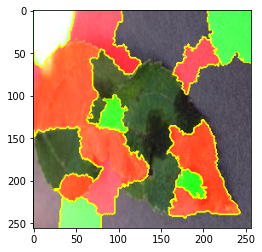

In [ ]:
img_boundary_all = mark_boundaries(temp_all / 255.0, mask_all)

plt.imshow(img_boundary_all)
plt.show()
